In [1]:
import pandas as pd
import numpy as np
import torch

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [9]:
from torchvision import datasets, transforms

In [139]:
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomResizedCrop(128, scale=(0.8,1.0)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomAffine(degrees=0, shear=10), 
    transforms.RandomPerspective(distortion_scale=0.3,p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [118]:
from torch.utils.data import random_split

In [140]:
train_dataset = datasets.ImageFolder(root='data/cat_vs_dog/training_set', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='data/cat_vs_dog/test_set', transform=test_transforms)

In [141]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

In [142]:
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [143]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [161]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d((1,1))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32,1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x

In [145]:
learning_rate = 0.0005
epochs=30

In [146]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            
    avg_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total
                        
            
    return avg_loss, accuracy            

In [151]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    history = {
        "training_loss": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            output = model(images).squeeze(1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)    
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # save history
        history['training_loss'].append(epoch_loss)        
        history['validation_loss'].append(val_loss)
        history['validation_accuracy'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")
        
    return  history         

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [149]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
12.1
1
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [162]:
model = CNN()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [163]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch [1/30] Train Loss: 0.6746 | Val Loss: 0.5257 | Val Acc: 60.02%
Epoch [2/30] Train Loss: 0.6637 | Val Loss: 0.5211 | Val Acc: 61.65%
Epoch [3/30] Train Loss: 0.6452 | Val Loss: 0.4927 | Val Acc: 65.65%
Epoch [4/30] Train Loss: 0.6261 | Val Loss: 0.5019 | Val Acc: 63.21%
Epoch [5/30] Train Loss: 0.6092 | Val Loss: 0.4787 | Val Acc: 66.46%
Epoch [6/30] Train Loss: 0.5873 | Val Loss: 0.4652 | Val Acc: 67.83%
Epoch [7/30] Train Loss: 0.5544 | Val Loss: 0.4452 | Val Acc: 71.83%
Epoch [8/30] Train Loss: 0.5312 | Val Loss: 0.4050 | Val Acc: 75.27%
Epoch [9/30] Train Loss: 0.4943 | Val Loss: 0.4448 | Val Acc: 73.70%
Epoch [10/30] Train Loss: 0.4690 | Val Loss: 0.3487 | Val Acc: 80.51%
Epoch [11/30] Train Loss: 0.4391 | Val Loss: 0.3092 | Val Acc: 83.26%
Epoch [12/30] Train Loss: 0.4128 | Val Loss: 0.3607 | Val Acc: 80.70%
Epoch [13/30] Train Loss: 0.3807 | Val Loss: 0.3441 | Val Acc: 80.07%
Epoch [14/30] Train Loss: 0.3650 | Val Loss: 0.2848 | Val Acc: 84.26%
Epoch [15/30] Train Loss: 0.3

In [164]:
loss, accuracy = evaluate_model(model, test_loader, criterion, device)
print("Accuracy:",accuracy)
print("Loss:",loss)

Accuracy: 91.84379634206624
Loss: 0.20687971432926133


In [165]:
history

{'training_loss': [0.6745996954132668,
  0.663737081176606,
  0.6451670755794392,
  0.6260820802171432,
  0.6092350555593101,
  0.5872904622732703,
  0.5544458175476511,
  0.5311794473757199,
  0.4942543546655285,
  0.4689816992674301,
  0.4390546542346774,
  0.41275145387768153,
  0.3807117109423253,
  0.36501689885386185,
  0.3303920155140891,
  0.3087289475682956,
  0.3037352239092191,
  0.29739987312709515,
  0.2695727285312776,
  0.26602637154323544,
  0.26494570695493946,
  0.24933419752847497,
  0.23700578792474755,
  0.22390441186448087,
  0.22735221266968927,
  0.21859108638111038,
  0.20646472091772664,
  0.20138434887821996,
  0.20298554092200835,
  0.19912646866556424],
 'validation_loss': [0.5256728590466082,
  0.5210579494014382,
  0.4927108946722001,
  0.5019298472907394,
  0.4786975081078708,
  0.4651881502941251,
  0.44517118902876973,
  0.40501738619059324,
  0.444816785864532,
  0.3487445320934057,
  0.3091607333626598,
  0.36070626886794344,
  0.34411913342773914,
 

In [73]:
import matplotlib.pyplot as plt

In [111]:
def plot(target, label, plot_type):
    plt.plot(history[target], label=label)
    plt.xlabel("Epoch")
    plt.ylabel(plot_type)
    plt.title(f"{label} per Epoch")
    plt.legend()
    plt.show()

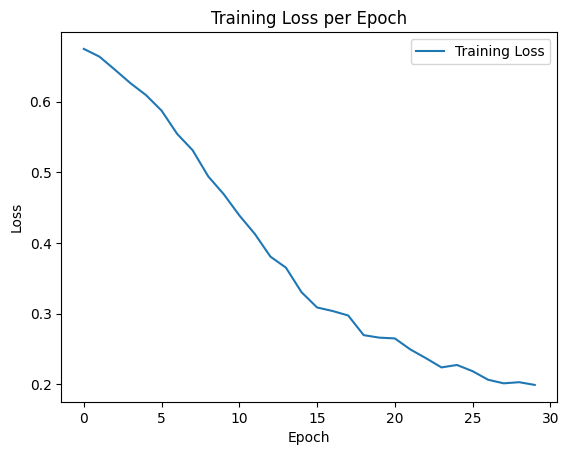

In [166]:
plot("training_loss", "Training Loss", "Loss")

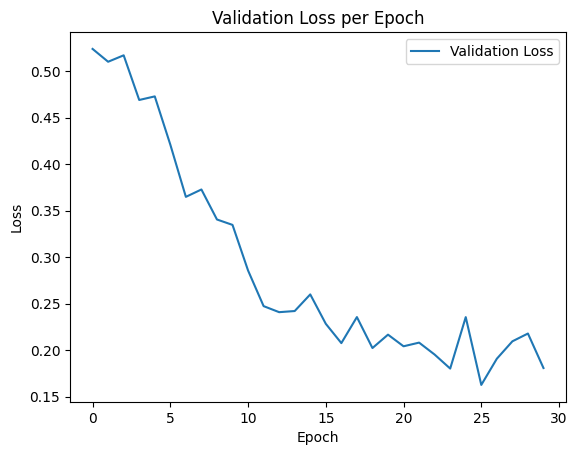

In [157]:
plot("validation_loss", "Validation Loss", "Loss")

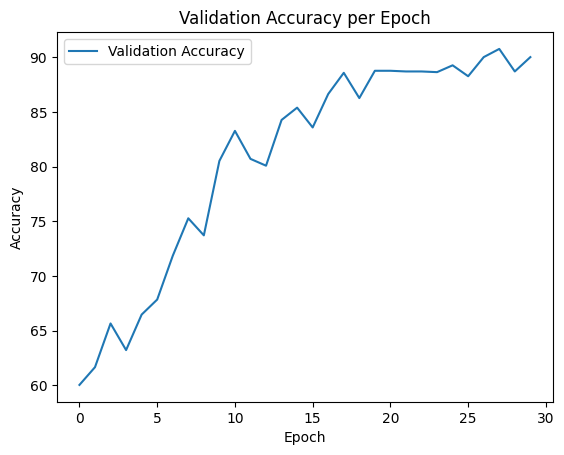

In [167]:
plot("validation_accuracy", "Validation Accuracy", "Accuracy")

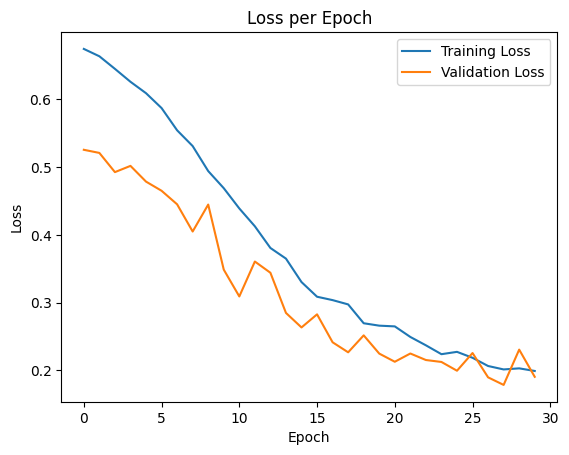

In [168]:
plt.plot(history["training_loss"], label="Training Loss")
plt.plot(history["validation_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss per Epoch")
plt.legend()
plt.show()